# Using NGLView

Germain Salvato Vallverdu, March 23, 2023

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import mdtraj as md

import nglview as nv

from pymatgen.core import Molecule, Structure
from pymatgen.io.gaussian import GaussianOutput

## Load and visualize one Molecule

In [2]:
mol = Molecule.from_file("data_nglview/norbornene.xyz")

In [3]:
view = nv.show_pymatgen(mol)
view

NGLWidget()

### Include / download

In order to include picture in the notebook, you have to excute the following lines:

1. Excute render image
2. Excute display image

This will produce a picture that will be included in the notebook if you export it as HTML. The orientation is the one corresponding to the current view.

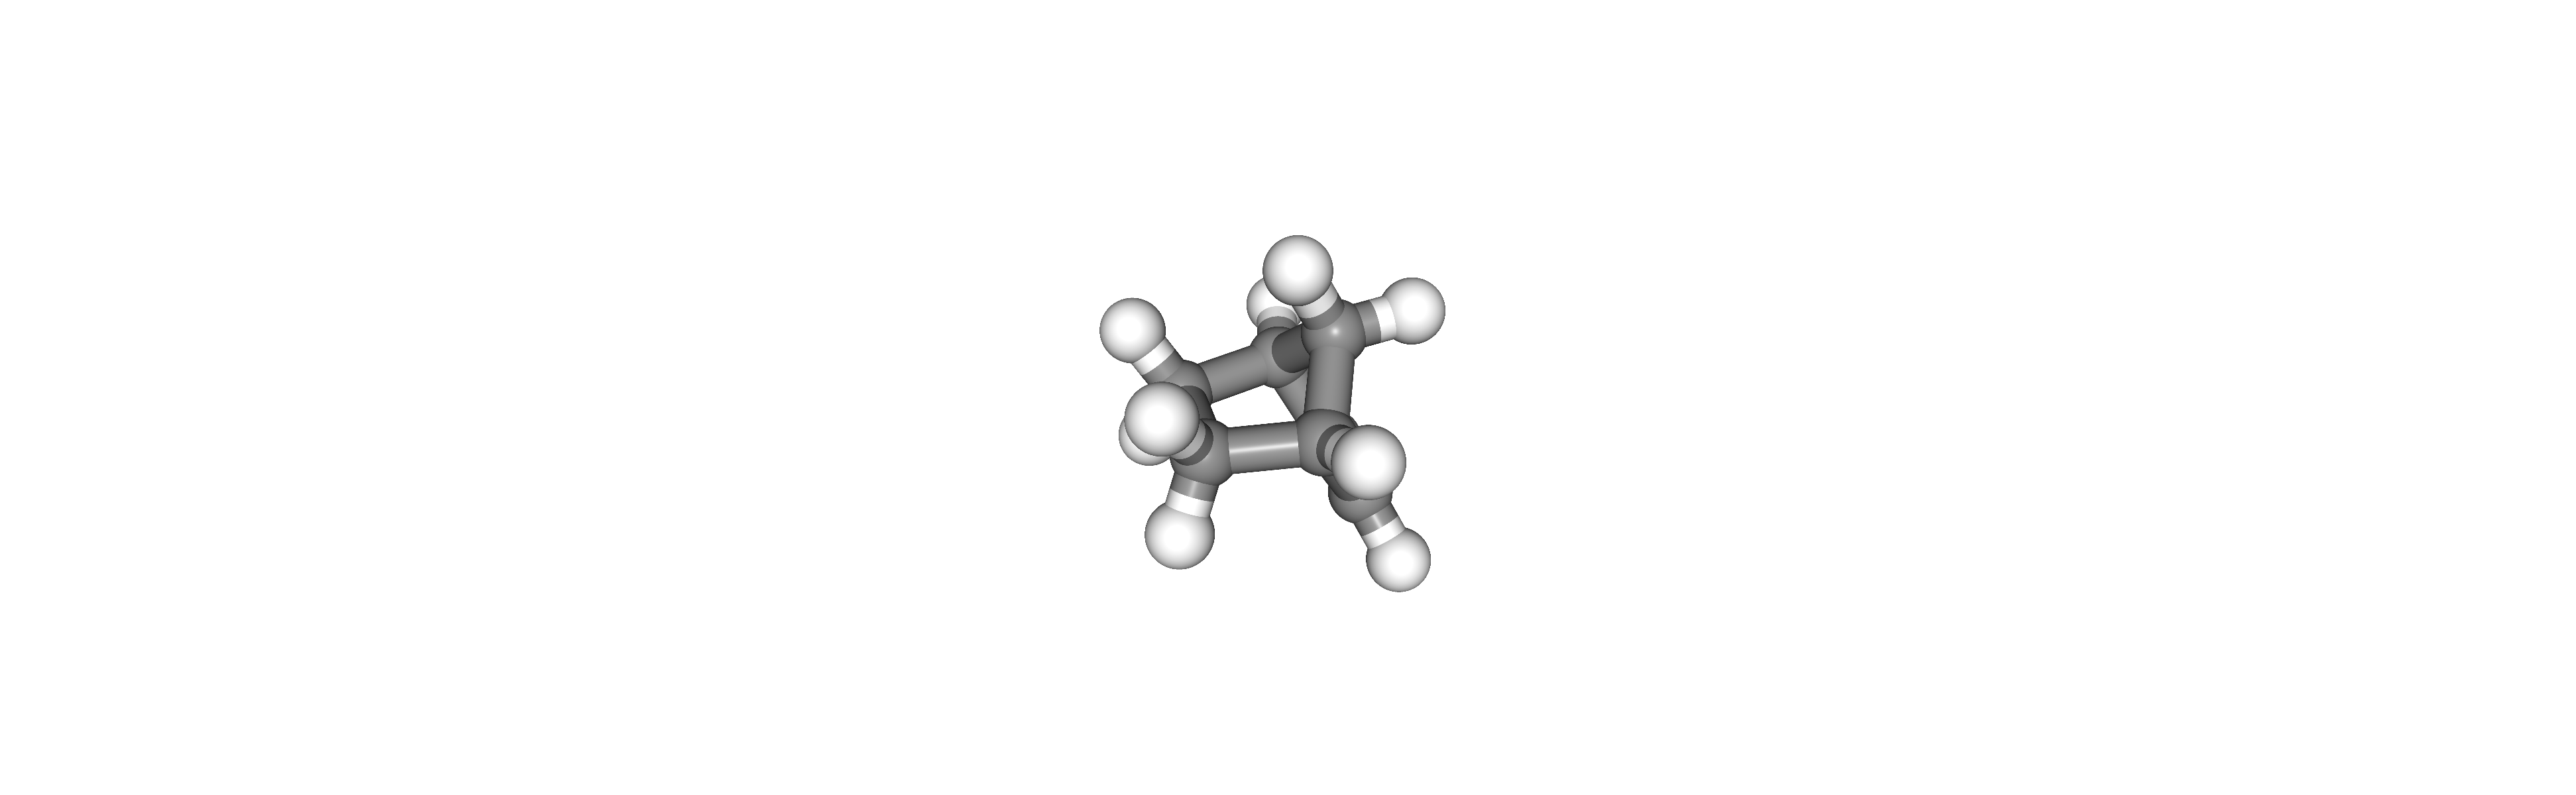

In [5]:
#view.render_image()
view._display_image()

Save image to file.

In [10]:
view.download_image(filename="norbornene.png")

### Add some elements

In [6]:
view = nv.show_pymatgen(mol)
view.add_label(label_type="serial", color="black")
view

NGLWidget()

In [8]:
labels = [f"{site.species_string}_{i}" for i, site in enumerate(mol, 1)]
view = nv.show_pymatgen(mol)
view.add_label(label_text=labels, label_type="text", color="black")
view

NGLWidget()

In [9]:
view = nv.show_pymatgen(mol)
view.add_distance(atom_pair=[[11, 15]], color="red", label_color="blue", label_unit="nm")
view

NGLWidget()

## Load and visualize a periodic Structure

In [10]:
s = Structure.from_file("data_nglview/LiMnO2.POSCAR.vasp")

In [11]:
s.lattice

Lattice
    abc : 5.4390001297 2.8090000153 5.394999980902391
 angles : 90.0 115.90000152649125 90.0
 volume : 74.1466127849419
      A : 5.4390001297 0.0 0.0
      B : 0.0 2.8090000153 0.0
      C : -2.3565457692 0.0 4.8531141375
    pbc : True True True

In [12]:
s.make_supercell([2, 4, 2])

In [13]:
view = nv.show_pymatgen(s)
view.add_unitcell()
view

NGLWidget()

## Visualize Gaussian optimization

In the following we 

* read molecular structures from Gaussian output file
* concatenate all xyz coordinates
* set up topology
* load it as a trajectory

In [14]:
opt = GaussianOutput("data_nglview/glypho.out")

In [15]:
len(opt.structures)

38

Concatenate all xyz coordinates

In [16]:
xyz = np.concatenate([mol.cart_coords[np.newaxis] for mol in opt.structures], axis=0)
xyz /= 10  # convert in nm

In [17]:
xyz.shape

(38, 18, 3)

In [18]:
# set up topologie using last structure

# first, set up the list of bonds
bonds = list()
for bond in opt.final_structure.get_covalent_bonds():
    iat = opt.final_structure.index(bond.site1)
    jat = opt.final_structure.index(bond.site2)
    bonds.append([iat, jat])

bonds = np.array(bonds, dtype=np.int64)

# data frame of atoms
natom = len(opt.final_structure)
df = pd.DataFrame({
    "serial": range(1, natom + 1),
    "name": [f"{site.species_string}{iat}" for iat, site in enumerate(opt.final_structure, 1)],
    "element": [site.specie.symbol for site in opt.final_structure],
    "resSeq": [1] * natom,
    "resName": "MOL",
    "chainID": 0,
})
top = md.Topology.from_dataframe(df, bonds)

In [19]:
traj = md.Trajectory(xyz, topology=top)

In [20]:
view = nv.show_mdtraj(traj)
view

NGLWidget(max_frame=37)

### Plot energy and forces convergence

In [42]:
def plot_conv(opt, threshold=0.000450):
    """ to be improved ... """
    
    # forces on atoms
    forces = np.array(opt.cart_forces)
    forces = forces.reshape(37, opt.final_structure.num_sites, 3)
    forces_norm = np.sqrt((forces ** 2).sum(axis=2)) 
    max_forces = forces_norm.max(axis=1) * 630 / 0.529  # conversion kcal/mol/A

    # energies
    energies = np.array(opt.energies)

    # plot
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8),
                                   gridspec_kw=dict(hspace=0))

    # plot energy
    ax1.plot((energies - energies.min()) * 630, "o--")
    ax1.set_ylabel("E (kcal/mol)")

    # plot forces
    ax2.plot(max_forces, "C1d--")
    axins = inset_axes(ax2, width="75%", height="50%")
    axins.plot(max_forces, "C1d--")
    axins.set_ylim(-1, 11)
    axins.axhline(threshold, color="C2", ls="--")

    ax2.axhline(threshold, color="C2", ls="--")
    ax2.set_ylabel("Max forces\n(kcal/mol/A)", color="C1")
    
    return fig    

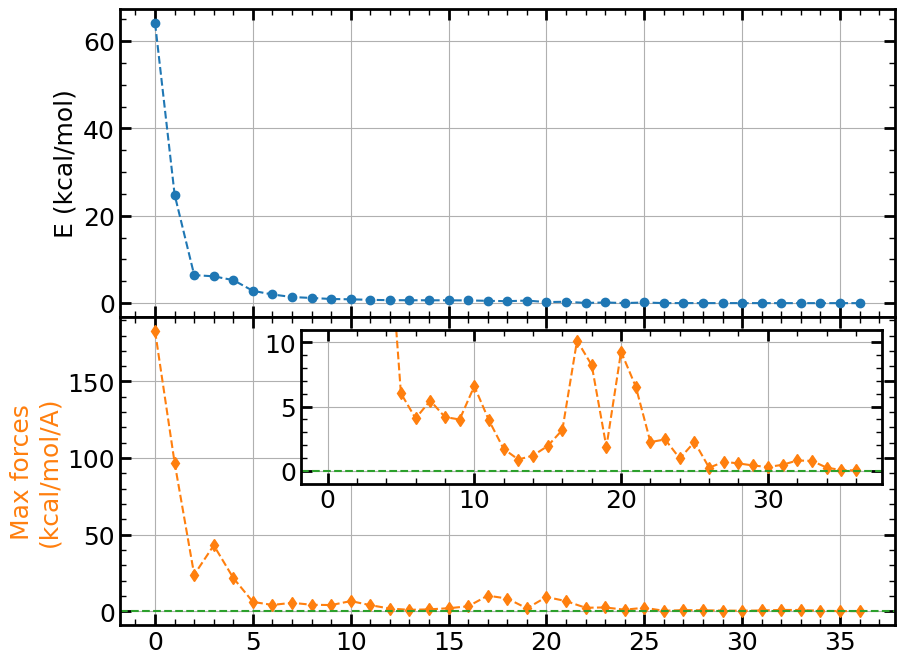

In [43]:
fig = plot_conv(opt)

PS: exit molden ;)